In [ ]:
import pandas as pd
import numpy as np 
import cv2
import PIL
import os
import keras
from glob import glob
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, concatenate
%matplotlib inline
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.applications import EfficientNetB0
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import plot_model

In [ ]:
df = pd.read_csv('C:\\Users\\Admin\\3D Objects\\Data_Entry_2017.csv')
image_paths = 'C:\\Users\\Admin\\3D Objects\\Chest X-ray data\\Denoised sample images_001'
print('Scans found:', len(image_paths), ', Total Headers', df.shape[0])

Scans found: 69 , Total Headers 112120


In [ ]:
df['path'] = df['Image Index'].map(image_paths.get)
df['Patient Age'] = df['Patient Age'].map(lambda x: int(x[:-1]) if isinstance(x, str) else x)
df.sample(3)

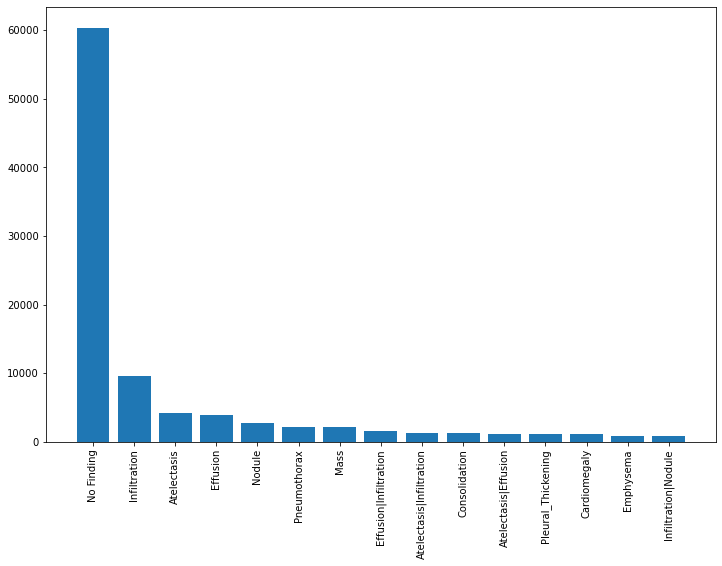

In [ ]:
## Visualizing the labels


label_counts = df['Finding Labels'].value_counts()[:15]
fig, ax1 = plt.subplots(1,1,figsize = (12, 8))
ax1.bar(np.arange(len(label_counts))+0.5, label_counts)
ax1.set_xticks(np.arange(len(label_counts))+0.5)
_ = ax1.set_xticklabels(label_counts.index, rotation = 90)

In [ ]:
df['Finding Labels'] = df['Finding Labels'].map(lambda x: x.replace('No Finding', ''))
from itertools import chain
all_labels = np.unique(list(chain(*df['Finding Labels'].map(lambda x: x.split('|')).tolist())))
all_labels = [x for x in all_labels if len(x)>0]
print('All Labels ({}): {}'.format(len(all_labels), all_labels))
for c_label in all_labels:
    if len(c_label)>1: # leave out empty labels
        df[c_label] = df['Finding Labels'].map(lambda finding: 1.0 if c_label in finding else 0)
df.sample(3)

All Labels (14): ['Atelectasis', 'Cardiomegaly', 'Consolidation', 'Edema', 'Effusion', 'Emphysema', 'Fibrosis', 'Hernia', 'Infiltration', 'Mass', 'Nodule', 'Pleural_Thickening', 'Pneumonia', 'Pneumothorax']


,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,...,Effusion,Emphysema,Fibrosis,Hernia,Infiltration,Mass,Nodule,Pleural_Thickening,Pneumonia,Pneumothorax
70943,00017504_021.png,Consolidation,21,17504,12,F,AP,2500,2048,0.168,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
58643,00014520_019.png,,19,14520,32,M,AP,2500,2048,0.168,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
105752,00028458_002.png,Atelectasis|Edema,2,28458,76,M,AP,3056,2544,0.139,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


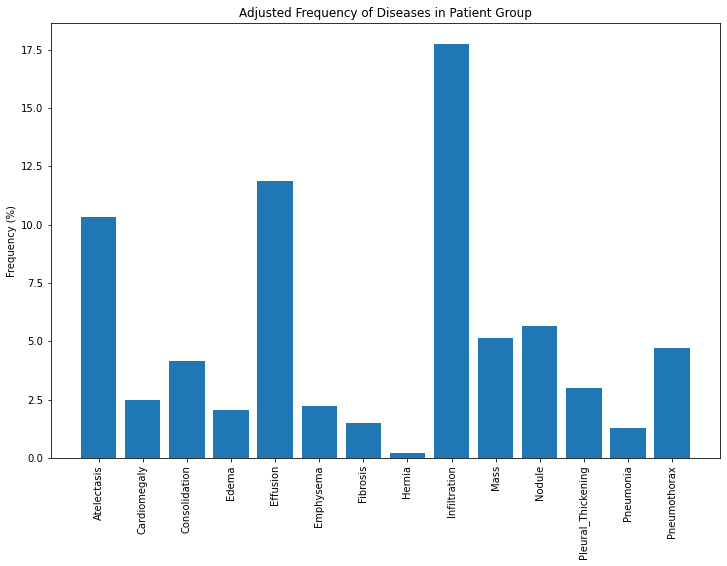

In [ ]:
label_counts = 100*np.mean(df[all_labels].values,0)
fig, ax1 = plt.subplots(1,1,figsize = (12, 8))
ax1.bar(np.arange(len(label_counts))+0.5, label_counts)
ax1.set_xticks(np.arange(len(label_counts))+0.5)
ax1.set_xticklabels(all_labels, rotation = 90)
ax1.set_title('Adjusted Frequency of Diseases in Patient Group')
_ = ax1.set_ylabel('Frequency (%)')

In [ ]:
labels = sorted(df['Finding Labels'].unique())
print(labels)
for label in labels:
    print("----- " + label)

['', 'Atelectasis', 'Atelectasis|Cardiomegaly', 'Atelectasis|Cardiomegaly|Consolidation', 'Atelectasis|Cardiomegaly|Consolidation|Edema', 'Atelectasis|Cardiomegaly|Consolidation|Edema|Effusion|Infiltration', 'Atelectasis|Cardiomegaly|Consolidation|Edema|Effusion|Infiltration|Mass', 'Atelectasis|Cardiomegaly|Consolidation|Edema|Effusion|Infiltration|Mass|Nodule', 'Atelectasis|Cardiomegaly|Consolidation|Edema|Effusion|Mass', 'Atelectasis|Cardiomegaly|Consolidation|Edema|Effusion|Pleural_Thickening', 'Atelectasis|Cardiomegaly|Consolidation|Effusion', 'Atelectasis|Cardiomegaly|Consolidation|Effusion|Infiltration', 'Atelectasis|Cardiomegaly|Consolidation|Effusion|Infiltration|Mass', 'Atelectasis|Cardiomegaly|Consolidation|Effusion|Infiltration|Mass|Pleural_Thickening', 'Atelectasis|Cardiomegaly|Consolidation|Effusion|Infiltration|Nodule|Pleural_Thickening', 'Atelectasis|Cardiomegaly|Consolidation|Effusion|Infiltration|Pneumonia', 'Atelectasis|Cardiomegaly|Consolidation|Effusion|Mass', 'Atel

In [ ]:
batch_size = 32
img_size = (224, 224)

In [ ]:
# Set up the data generators
datagen = ImageDataGenerator(rescale=1./255,
                                   shear_range=0.2,
                                   zoom_range=0.2,
                                   horizontal_flip=True)
datagen = ImageDataGenerator(rescale=1./255)
generator = datagen.flow_from_dataframe(dataframe=df,
                                        directory='C:\\Users\\Admin\\3D Objects\\Chest X_ray (samples)\\images 5 samples', 
                                        x_col='Image Index',
                                        y_col='Finding Labels',
                                        target_size=img_size,
                                        batch_size=batch_size,
                                        class_mode='categorical')

Found 200 validated image filenames belonging to 36 classes.


In [ ]:
# Build the model
input_tensor = Input(shape=(img_size[0], img_size[1], 3))
base_model = EfficientNetB0(include_top=False, input_tensor=input_tensor, pooling='avg', weights='imagenet')
x = base_model.output
x = Dense(1, activation='sigmoid')(x)
model = Model(inputs=input_tensor, outputs=x)

In [ ]:
# Freeze the layers in the base model
for layer in base_model.layers:
    layer.trainable = False

In [ ]:
# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [ ]:
# Train the model
steps_per_epoch = generator.n // batch_size
epochs = 10
model.fit(generator, steps_per_epoch=steps_per_epoch, epochs=epochs)

Epoch 1/10
6/6 [==============================] - 35s 3s/step - loss: 0.3279 - accuracy: 0.9722
Epoch 2/10
6/6 [==============================] - 17s 3s/step - loss: 0.1640 - accuracy: 0.9722
Epoch 3/10
6/6 [==============================] - 18s 3s/step - loss: 0.1329 - accuracy: 0.9722
Epoch 4/10
6/6 [==============================] - 17s 2s/step - loss: 0.1284 - accuracy: 0.9722
Epoch 5/10
6/6 [==============================] - 17s 3s/step - loss: 0.1288 - accuracy: 0.9722
Epoch 6/10
6/6 [==============================] - 19s 3s/step - loss: 0.1301 - accuracy: 0.9722
Epoch 7/10
6/6 [==============================] - 15s 2s/step - loss: 0.1308 - accuracy: 0.9722
Epoch 8/10
6/6 [==============================] - 18s 3s/step - loss: 0.1299 - accuracy: 0.9722
Epoch 9/10
6/6 [==============================] - 18s 3s/step - loss: 0.1292 - accuracy: 0.9722
Epoch 10/10
6/6 [==============================] - 18s 3s/step - loss: 0.1285 - accuracy: 0.9722


In [ ]:
# Evaluate the model on the same data
scores = model.evaluate(generator, verbose=0)
print('Accuracy:', scores[1])

Accuracy: 0.9722222089767456
